In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
from IPython.display import HTML, Video,display
from csbdeep.utils import normalize
import numpy as np
import tifffile as tiff
import imageio.v3 as iio
from tqdm import tqdm
import re
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from src import *

# DeepCAD-RT Training

ℹ️ This notebook visualizes the trainings made with [deepcad_train.py](deepcad_train.py).

Please refer to the script to run the training. The provided configuration run in about 1h on 3 A100 64GB GPUs.

## 1. Convert test video from TIFF to MP4

In [3]:
dir = Path("./pth/resonant_neuro_202508022117")
result_folder = 5
prediction_dir = Path(f"results/{result_folder}")
prediction_dir.mkdir(exist_ok=True)

for file in tqdm(dir.glob("*.tif")):
    Recording(file).render(f"results/{result_folder}/{file.stem}.mp4")

0it [00:00, ?it/s]

10it [00:25,  2.56s/it]


In [5]:
for file in Path(f"results/{result_folder}").glob("*.mp4"):
    cprint("Showing", f"green:{file}")
    display(Video(url=str(file)))

Showing results/3/oabf_astrof_E_20_Iter_1009_output.mp4


Showing results/3/oabf_resonant_neurof_E_20_Iter_1009_output.mp4


Showing results/3/oabf_vpmf_E_20_Iter_1009_output.mp4


Results are completely black when changing footage from the train set.

## 2. Comparing training results with given baseline

In [ ]:
baseline_file=Path("../dataset/sample/deepcad/oabf_good_example.tiff")
prediction_file=list(prediction_dir.glob("*.mp4"))[-1]

In [54]:
baseline = tiff.imread(baseline_file)
baseline /= np.max(baseline)
baseline = normalize(baseline, 1, 99)
baseline = np.clip(baseline, max=1)

prediction = iio.imread(prediction_file).astype(np.float64)
prediction /= np.max(prediction)

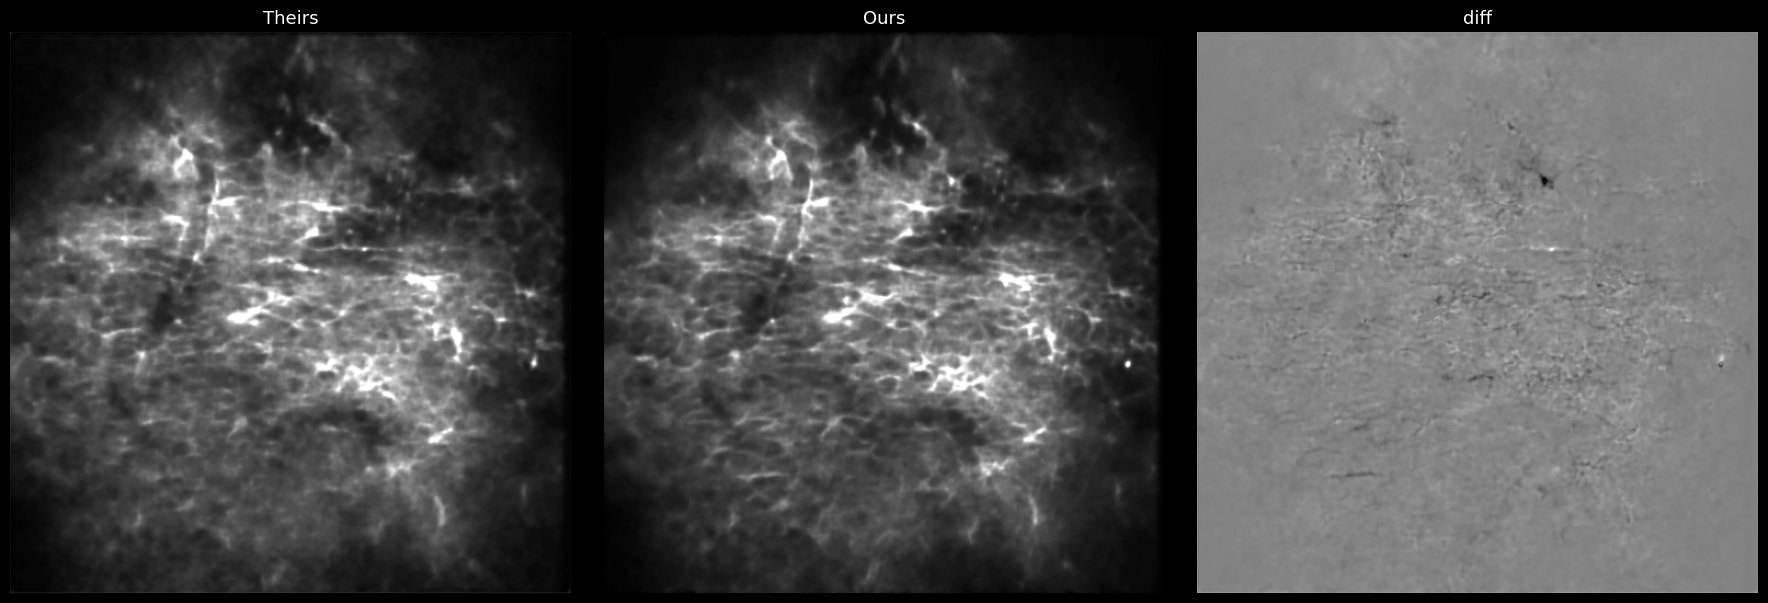

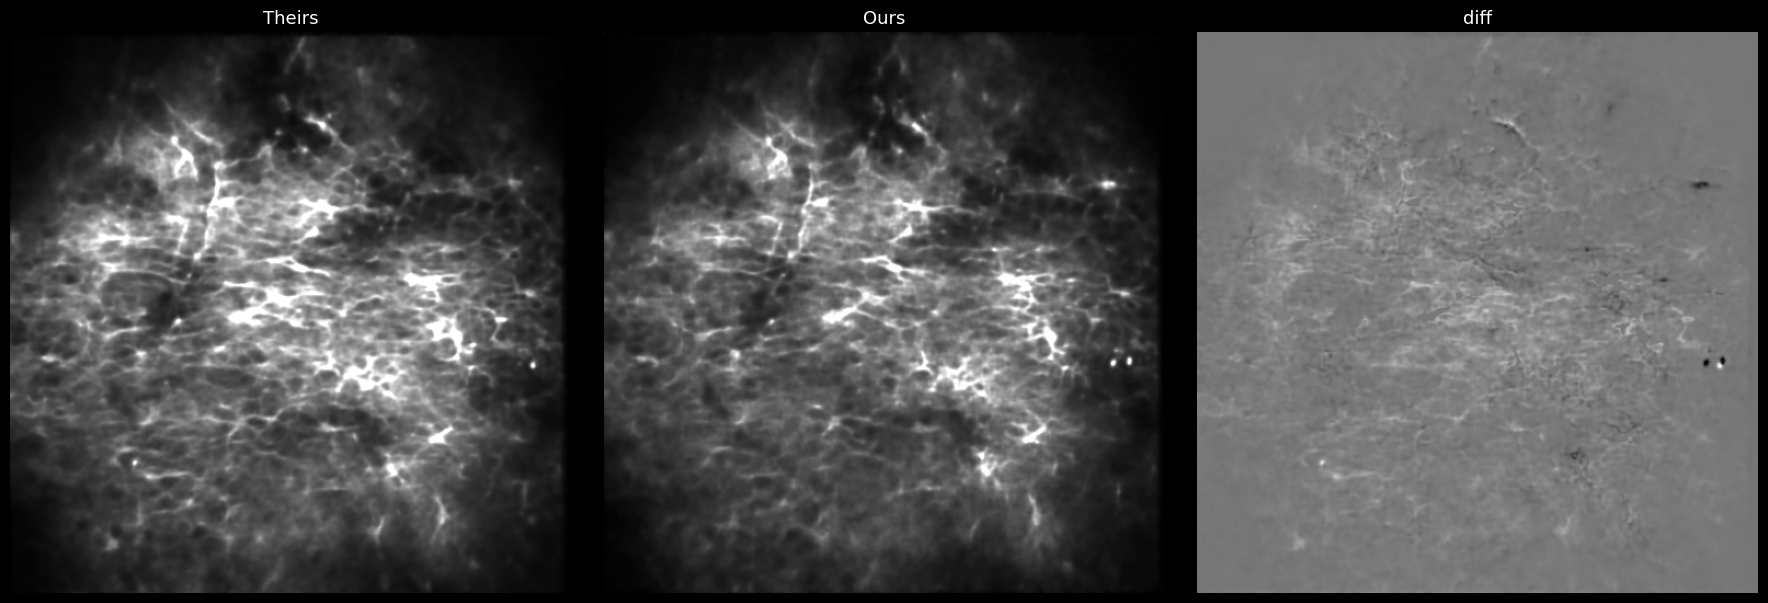

In [56]:
for frame in [0, -1]:
    imshow(
        {"Theirs": baseline[frame], "Ours": prediction[frame], "diff": baseline[frame] - prediction[frame, :, :, 0]},
        size=6,
        cmap="grey",
    )

## 3. Extract loss trend from logs

In [8]:
log_path = Path(f"results/2/log")

In [9]:
l1 = []
with open(log_path) as f:
    for line in tqdm(_ for _ in f.readlines() if "[Total loss:" in _):
        if match := re.search(r"L1 Loss: ([\d\.eE+-]+)", line):
            l1.append(float(match.group(1)))

20180it [00:00, 765449.01it/s]


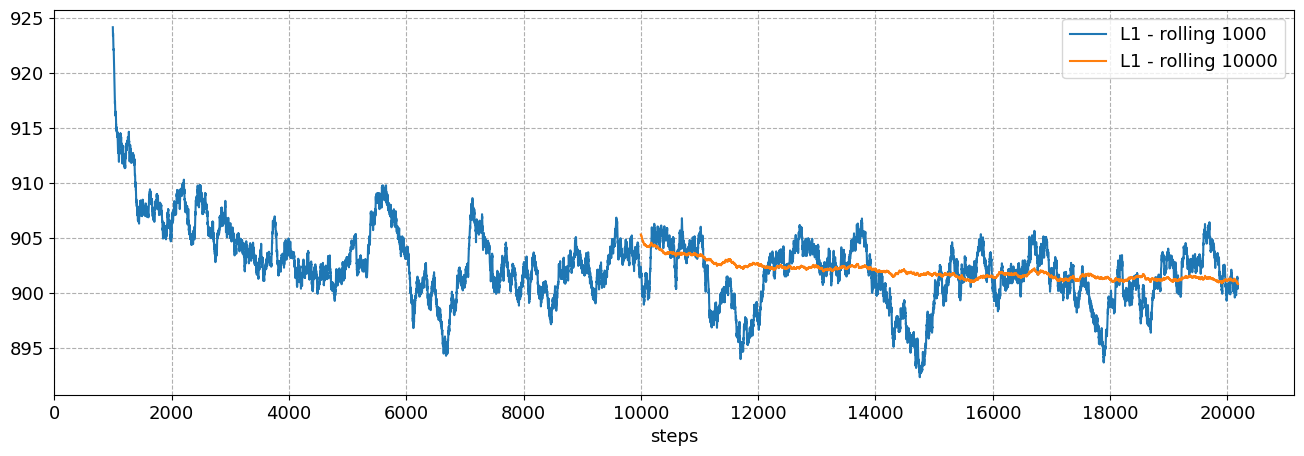

In [10]:
l1 = pd.Series(l1)
df = pd.DataFrame(
    {
        "steps": range(len(l1)),
        "L1 - rolling 1000": l1.rolling(1000).mean(),
        "L1 - rolling 10000": l1.rolling(10000).mean(),
    }
)
ax = df.plot(x="steps", figsize=(16, 5))
ax.set_xticks(range(0, len(df), 2000));